# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> Data Science 2: Advanced Topics in Data Science 
## Homework 3 - Bayesian Analysis



**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors**: Mark Glickman, Pavlos Protopapas, & Chris Tanner 


<hr style="height:2pt">

### Homework 3 is due March 5th

In [1]:
#PLEASE RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

- To submit your assignment, please follow the instructions on Canvas.
- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

### Please use the libraries below:

In [2]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
%matplotlib inline 
from datetime import datetime as dt
from scipy.special import expit

In [3]:
# Ignore pesky warnings (they are coming from library functions, not our code)
import warnings
messages=[
#    'Using a non-tuple sequence for multidimensional indexing is deprecated',
    'Argument backend_kwargs has not effect in matplotlib',
]
for m in messages:
    warnings.filterwarnings("ignore", message=m)


<hr style="height:2pt">

### Contraceptive Usage by Bangladeshi Women

In the second part of this assignment, you are provided with data sets `dataset_2_train.csv` and `dataset_2_test.csv`containing details of contraceptive usage by 1934 Bangladeshi women. There are four attributes for each woman, along with a label indicating if she uses contraceptives. The attributes include
* district: identifying code for the district the woman lives in
* urban: type of region of residence
* living.children: number of living children
* age-mean: age of the woman (in years, centered around mean)

The women are grouped into 60 districts. The task is to build a classification model that can predict if a given woman uses contraceptives.


### Part A: Bayesian Logistic Regression

The first model we will fit to the contraceptives data is a varying-intercept logistic regression model, where the intercept varies by district.

Prior distribution:

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma^2_0} \sim \text{Gamma}(0.1,0.1)$.

$\beta_1 \sim N(0,10000)$, $\beta_2\sim N(0,10000)$, $\beta_3 \sim N(0,10000)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_1 \times \text{urban} + \beta_2 \times \text{living.children} + \beta_3 \times \text{age-mean}$,

where $Y_{ij}$ is 1 if woman $i$ in district $j$ uses contraceptives, and 0 otherwise, and where $i \in \{1,...,N\}$ and $j \in \{1,...,J\}$. $N$ is the number of observations in the data, and $J$ is the number of districts. The above notation assumes $N(\mu, \sigma^2)$ is a Normal distribution with mean $\mu$ and variance $\sigma^2$.

##### **A1**

As a preprocessing step, map the district number 61 to the number 54 so that the districts are in order. Also, re-name district 60 to be district 0 so that the districts are numbered 0 through 59. **We use this numbering throughout the homework, and will grade using these district numbers**

In [4]:
#your code here
train_data = pd.read_csv("data/dataset_2_train.csv")
test_data = pd.read_csv("data/dataset_2_test.csv")

train_data.loc[train_data['district']==61,'district'] = 54
test_data.loc[test_data['district']==61,'district'] = 54

train_data.loc[train_data['district']==60,'district'] = 0
test_data.loc[test_data['district']==60,'district'] = 0

##### **A2**

First, we'll verify that pymc3 can recover the hidden parameter values. To do so, we'll hard-code known values and simulate data from the model, then using that data we'll check if pymc3 can get back the parameters we hard-coded. If it does, we'll have hope that it can get the hidden parameter values that generated the real data.

Use the following hard-coded values:  
$\mu_0 = 2$

$\sigma^2_0 = 1$

$\beta_{0j} \sim N(\mu_0,\sigma_0^2)$ for all sixty districts

$\beta_1 = 4$

$\beta_2 = -3$

$\beta_3 = -2$

**Verify that these parameters give an overall average of 46 to 48 percent of subjects using contraceptives**

In [5]:
mu_a = 2
sigma_a = 1

# draw the beta_0 to be used in each district
sim_beta0 = np.random.normal(mu_a,sigma_a, 60)
sim_beta1 = 4
sim_beta2 = -3
sim_beta3 = -2

synthetic_resp = []
for index, row in train_data.iterrows():
    rawval = sim_beta0[int(row.district)] + sim_beta1*row['urban'] + sim_beta2*row['living.children'] + sim_beta3*row['age_mean']
    synthetic_resp.append(np.random.binomial(1,expit(rawval)))

synthetic_resp = np.array(synthetic_resp)
np.mean(synthetic_resp)

0.4756980351602896

##### **A3**

Fit the varying-intercept model specified above to your simulated data. Reasonably good convergence may require adjustments to the number of tuning samples and the target acceptance rate as suggested in pymc3's warnings.

In [6]:
with pm.Model() as district_intercept_model:
    
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    inv_sigma2_inv = pm.Gamma('sig2_inv_0', alpha=.1, beta=.1)

#     # non-centered paramaterization: https://us.edstem.org/courses/172/discussion/17838 
#     beta0_vec_stand = pm.Normal('beta_0_stand', mu=0, tau=1, shape=60)
#     beta0_vec = pm.Deterministic('beta0', mu_0 + (beta0_vec_stand * inv_sigma2_inv))
    
    beta0_vec = pm.Normal('beta_0', mu=mu_0, tau=inv_sigma2_inv, shape=60)
    
    beta1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta2 = pm.Normal('beta_2', mu=0, sigma=100)
    beta3 = pm.Normal('beta_3', mu=0, sigma=100)
    
#     # one could use the Deterministic constructor 
#     p_ij = pm.Deterministic('$P_ij$', pm.math.invlogit(beta0_vec[train_data['district']] 
#                                                        + beta1*train_data['urban']
#                                                        + beta2*train_data['living.children']
#                                                        + beta3*train_data['age_mean']
#                                                       )
#                            )
#     use = pm.Bernoulli('useage', p=p_ij, observed=synthetic_resp)

    use = pm.Bernoulli('useage', logit_p=beta0_vec[train_data['district'].values] 
                                       + beta1*train_data['urban']
                                       + beta2*train_data['living.children']
                                       + beta3*train_data['age_mean'], 
                       observed=synthetic_resp
                      )
    sim_data_trace = pm.sample(20000, tune=20000, target_accept=0.98)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_3, beta_2, beta_1, beta_0, sig2_inv_0, mu_0]
Sampling chain 1, 0 divergences: 100%|██████████| 40000/40000 [10:03<00:00, 66.33it/s] 
The number of effective samples is smaller than 10% for some parameters.


In [7]:
sim_results_frame = pm.summary(sim_data_trace, var_names=['mu_0', 'sig2_inv_0', 'beta_0', 'beta_1', 'beta_2', 'beta_3'])
sim_results_frame

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,1.106,0.763,-0.359,2.489,0.026,0.018,866.0,866.0,866.0,1723.0,1.0
sig2_inv_0,3.340,4.589,0.144,10.659,0.166,0.118,761.0,761.0,802.0,1171.0,1.0
beta_0[0],1.002,1.113,-1.075,3.151,0.026,0.019,1809.0,1809.0,1766.0,4502.0,1.0
beta_0[1],1.313,1.038,-0.668,3.260,0.028,0.020,1327.0,1327.0,1316.0,3354.0,1.0
beta_0[2],1.184,1.156,-1.038,3.368,0.027,0.019,1792.0,1792.0,1738.0,4678.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta_0[58],1.145,1.105,-0.941,3.227,0.025,0.018,1884.0,1884.0,1819.0,5269.0,1.0
beta_0[59],1.094,1.189,-1.147,3.408,0.026,0.018,2153.0,2153.0,2034.0,5860.0,1.0
beta_1,3.806,0.768,2.401,5.262,0.012,0.008,4137.0,4136.0,4201.0,9641.0,1.0
beta_2,-2.234,0.364,-2.923,-1.563,0.010,0.007,1334.0,1334.0,1322.0,3465.0,1.0


##### **A4**

Plot the trace plots of the MCMC sampler for the parameters $\mu_0, \frac{1}{\sigma^2_0}\text{ (a.k.a., }\tau_0\text{)}, \beta_1, \beta_2, \beta_3$. Based on these and the R-hat values, does it look like the samplers converged?

In [8]:
sim_results_frame.loc[sim_results_frame["r_hat"] > 1.05,:]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat


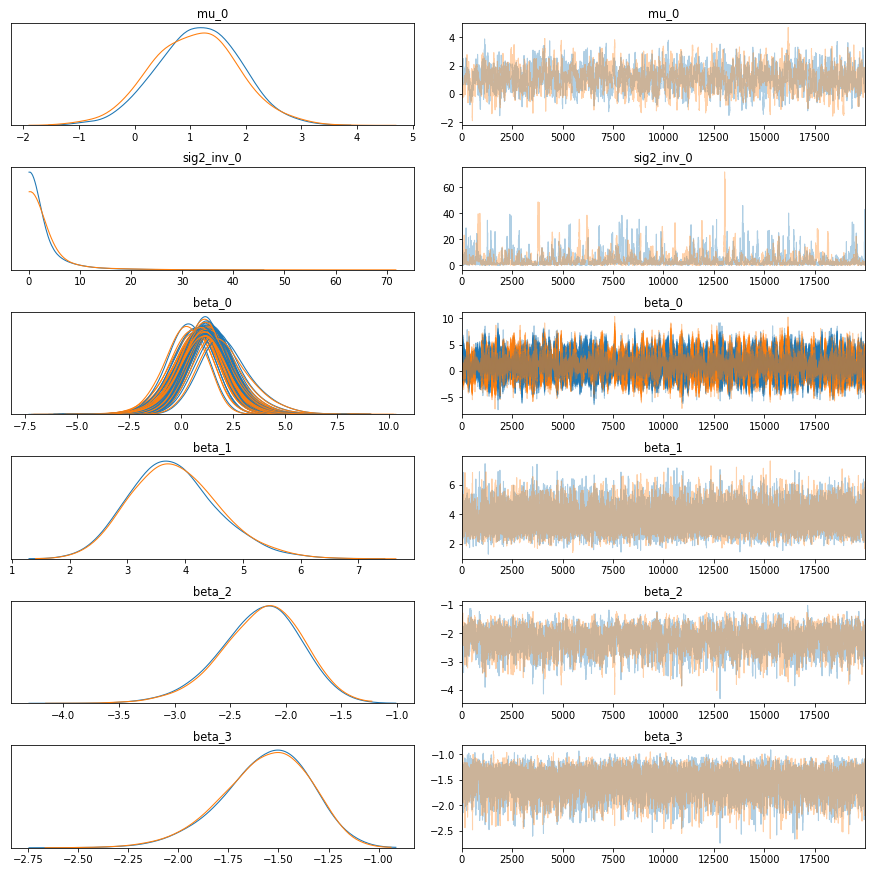

In [9]:
pm.traceplot(sim_data_trace, var_names=['mu_0', 'sig2_inv_0', 'beta_0', 'beta_1', 'beta_2', 'beta_3']);

your response here

**Answer:**

<div style='color:blue'>The trace plots show reasonable convergance among the four chains, and the R-hat values are all close to 1. 

However (beyond the scope of 109b, see e.g. AM 207...) the divergances, which coincide with large values of sigma^2 inverse (i.e. very small sigma^2 values), could indicate that our samples are not fully exploring the posterior distribution. There may be substantially more probability mass on small values of sigma^2 (and thus small values of beta0) than is reflected in our collected samples- that's one reason why the traces can get 'stuck' in those regions; it's trying to include enough samples from those areas.</div>

##### **A5**

Plot histograms of the posterior distributions for the parameters $\beta_{0,9}$, $\beta_{0,19}$, $\beta_{0,29}$, ..., $\beta_{0,59}$. Are the actual parameters that you generated contained within these posterior distributions? 

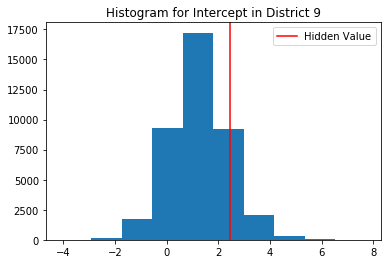

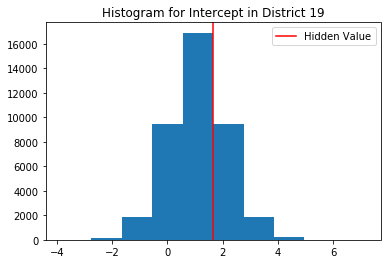

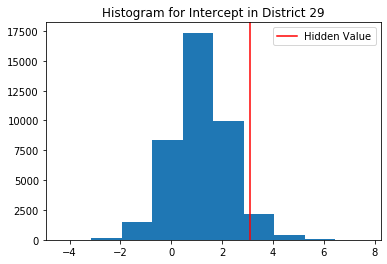

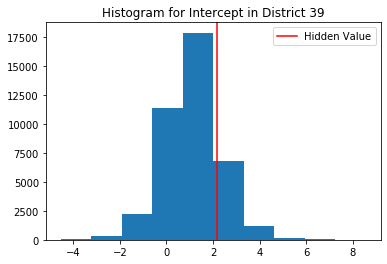

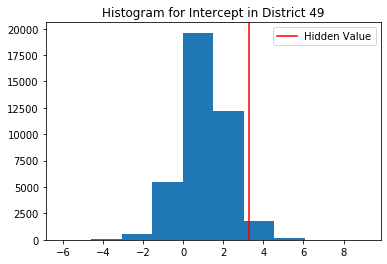

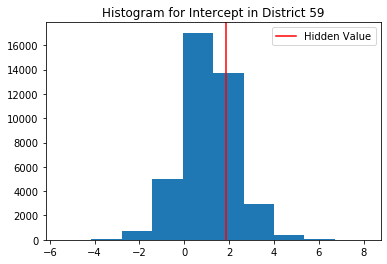

In [10]:
for cur_district in [9,19,29,39,49,59]:
    
    actual_beta = sim_beta0[cur_district]
    plt.hist(sim_data_trace['beta_0'][:,cur_district])
    plt.axvline(actual_beta, label="Hidden Value", c='r')
    plt.title("Histogram for Intercept in District {}".format(cur_district))
    plt.legend()
    plt.show()

your response here

**Answer:**

<div style='color:blue'>Yes, all of the true parameters are contained within the posterior distributions from our model. This suggests that we can move forward with fitting the model to the actual training data.</div>

##### **A6**

We now fit our model to the actual data. Fit the varying-intercept model to the real training data.

In [11]:
with pm.Model() as district_intercept_model:
    
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    inv_sigma2_inv = pm.Gamma('sig2_inv_0', alpha=.1, beta=.1)
    
    beta0_vec = pm.Normal('beta_0', mu=mu_0, tau=inv_sigma2_inv, shape=60)
    
    beta1 = pm.Normal('beta_1', mu=0, sigma=100)
    beta2 = pm.Normal('beta_2', mu=0, sigma=100)
    beta3 = pm.Normal('beta_3', mu=0, sigma=100)
    
#     p_ij = pm.Deterministic('$P_ij$', pm.math.invlogit(beta0_vec[train_data['district']] 
#                                                        + beta1*train_data['urban']
#                                                        + beta2*train_data['living.children']
#                                                        + beta3*train_data['age_mean']
#                                                       )
#                            )
    
#     use = pm.Bernoulli('useage', p=p_ij, observed=synthetic_resp)

    use = pm.Bernoulli('useage', logit_p=beta0_vec[train_data['district'].values] 
                                       + beta1*train_data['urban']
                                       + beta2*train_data['living.children']
                                       + beta3*train_data['age_mean'], 
                       observed=train_data['contraceptive_use']
                      )
    intercept_model_trace = pm.sample(12000, tune=9000, target_accept=0.925)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_3, beta_2, beta_1, beta_0, sig2_inv_0, mu_0]
Sampling chain 1, 0 divergences: 100%|██████████| 21000/21000 [01:19<00:00, 265.61it/s]
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8315943270594007, but should be close to 0.925. Try to increase the number of tuning steps.
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


##### **A7**

Check the convergence by examining the trace plots and R-hats, as you did with the simulated data. What do you observe?

In [12]:
intercept_results_frame = pm.summary(intercept_model_trace, var_names=['mu_0', 'sig2_inv_0', 'beta_0', 'beta_1', 'beta_2', 'beta_3'])

sim_results_frame.loc[sim_results_frame["r_hat"] > 1.05,:]

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat


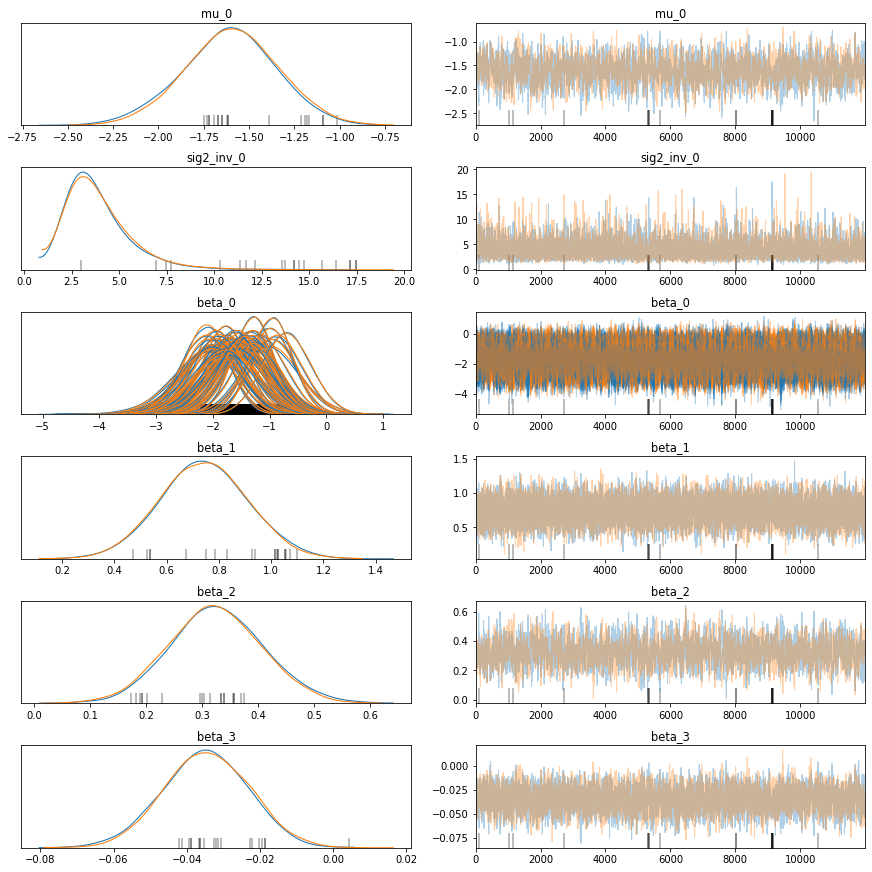

In [13]:
pm.traceplot(intercept_model_trace, var_names=['mu_0', 'sig2_inv_0', 'beta_0', 'beta_1', 'beta_2', 'beta_3']);

your response here

**Answer:**

<div style='color:blue'>The converegence here looks very good- even better than on the simulated data. All chains agree on the posterior for each parameter, and the traces show mostly random walks. The R-hat values are all close to 1.

(Advanced) Per pymc3's warning, some traces e.g. mu0 or beta2 show auto-correlation: the value 1, 10, or 100 steps forward can be predicted pretty well by knowing the present value. That means we're learning less per-sample than if all samples were unpredictable. Although we physically drew 5,000 mu0 values we've only learned as much as drawing 500 truly independent values (the 'effective sample size' warning). We could combat this by simply running the sampler for longer. </div>

##### **A8**

Based on the posterior means, which district has the highest base rate of contraceptive usage (independent of other factors like urban population)? Which district has the lowest?

In [14]:
posterior_mean_beta0s = np.mean(intercept_model_trace['beta_0'], axis=0)
max_dist, min_dist = np.argmax(posterior_mean_beta0s), np.argmin(posterior_mean_beta0s)

print("Most Likely: District {}".format(max_dist))
print("Least Likely: District {}".format(min_dist))

Most Likely: District 56
Least Likely: District 11


your response here

**Answer:**

<div style='color:blue'>It appears that women from district 56 tend to be the most likely to use contraceptives, and women from district 11 tend to be the least likely to use contraceptives, holding other factors constant.</div>

##### **A9**

What are the posterior means of $\mu_0$ and $\sigma^2_0$? Do these values offer any evidence in support of or against the varying-intercept model, compared to a model with a single intercept value for all districts or a model with an intercept of 0 for all districts?

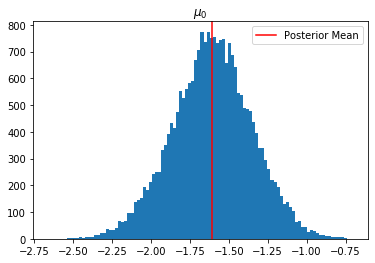

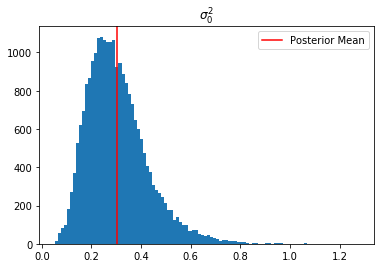

In [15]:
mu_mean = np.mean(intercept_model_trace['mu_0'])
plt.hist(intercept_model_trace['mu_0'], bins=100)
plt.axvline(mu_mean, c='r', label="Posterior Mean")
plt.legend()
plt.title("$\mu_0$")
plt.show()

sigma_mean = np.mean(1/intercept_model_trace['sig2_inv_0'])
plt.hist(1/intercept_model_trace['sig2_inv_0'], bins=100)
plt.axvline(sigma_mean, c='r', label="Posterior Mean")
plt.title("$\sigma^2_0$")
plt.legend()
plt.show()

In [16]:
print('Posterior mean of mu_0: {}'.format(np.mean(mu_mean)))
print('Posterior mean of sigma_0: {}'.format(np.mean(sigma_mean)))

Posterior mean of mu_0: -1.6068656944484416
Posterior mean of sigma_0: 0.30317808397196944


**Answer:**

<div style='color:blue'>The mu_0 posterior tells us that the center of the intercept-generating distribution could be anywhere from roughly -2.25 to -1. The sigma_0 posterior tells us that the spread of the intercept-generating distribution could be anything from roughly 0.1 to 0.8, with a high probability of values between 0.1 and 0.5.

There are two readings of this result:  
A) the fit has selected a meaningful spread in the district intercepts, and has ruled out a particularly low spreads (sigma_0 has no mass towards 0). Therefore, our posterior belief is that a model with a particularly small $\sigma_0^2$ (i.e. a shared intercept) would not work well.  
(However, it is notable that our prior puts extremely little mass on small values of $\sigma_0^2$, so not having posterior mass there is to be expected)  
B) the spread among district's intercepts that the model deems realistic is comparable to our uncertainty in the location of the intercept-generating distribution. Therefore, there is little evidence in favor of allowing the intercepts to differ.</div>

### Part B: Varying-Coefficients Model

The next model we will fit to the contraceptives data is a varying-coefficients logistic regression model, where the coefficients on living.children, age-mean, and urban vary by district.

$\beta_{0j} \sim N(\mu_0,\sigma_0^2),$ with $\mu_0 \sim N(0,10000)$ and $\frac{1}{\sigma_0^2} \sim \text{Gamma}(0.1,0.1)$.

$\beta_{1j} \sim N(0,\sigma_1^2)$, with $\frac{1}{\sigma^2_1} \sim \text{Gamma}(0.1,0.1)$

$\beta_{2j}\sim N(0,\sigma_2^2)$, with $\frac{1}{\sigma^2_2}\sim \text{Gamma}(0.1,0.1)$

$\beta_{3j} \sim N(0,\sigma_3^2)$, with $\frac{1}{\sigma^2_3} \sim \text{Gamma}(0.1,0.1)$

Model for data:

$Y_{ij} \sim \text{Bernoulli}(p_{ij})$

$\text{logit}\:p_{ij} = \beta_{0j} + \beta_{1j} \times \text{urban} + \beta_{2j} \times \text{living.children} + \beta_{3j} \times \text{age-mean}$,

##### **B1**

Fit the model to the real data. Plot posterior means for each of the coefficients to the predictors. What do you conclude from these graphs?

In [17]:
with pm.Model() as district_intercept_model:
    
    mu_0 = pm.Normal('mu_0', mu=0, sigma=100)
    
    sigma0_2inv = pm.Gamma('sig0_2inv', alpha=.1, beta=.1)
    
    sigma1_2inv = pm.Gamma('sig1_2inv',.1,.1)
    sigma2_2inv = pm.Gamma('sig2_2inv',.1,.1)
    sigma3_2inv = pm.Gamma('sig3_2inv',.1,.1)
    
    beta0_vec = pm.Normal('beta_0', mu=mu_0, tau=sigma0_2inv, shape=60)
    beta1_vec = pm.Normal('beta_1', mu=0, tau=sigma1_2inv, shape=60)
    beta2_vec = pm.Normal('beta_2', mu=0, tau=sigma2_2inv, shape=60)
    beta3_vec = pm.Normal('beta_3', mu=0, tau=sigma3_2inv, shape=60)
    
#     p_ij = pm.Deterministic('$P_ij$', pm.math.invlogit(beta0_vec[train_data['district']] 
#                                                        + beta1_vec[train_data['district']*train_data['urban']
#                                                        + beta2_vec[train_data['district']*train_data['living.children']
#                                                        + beta3_vec[train_data['district']*train_data['age_mean']
#                                                       )
#                            )
    
#     use = pm.Bernoulli('useage', p=p_ij, observed=synthetic_resp)

    use = pm.Bernoulli('useage', logit_p=beta0_vec[train_data['district'].values] 
                                           + beta1_vec[train_data['district'].values]*train_data['urban']
                                           + beta2_vec[train_data['district'].values]*train_data['living.children']
                                           + beta3_vec[train_data['district'].values]*train_data['age_mean'], 
                       observed=train_data['contraceptive_use']
                      )
    big_model_trace = pm.sample(13000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta_3, beta_2, beta_1, beta_0, sig3_2inv, sig2_2inv, sig1_2inv, sig0_2inv, mu_0]
Sampling chain 1, 0 divergences: 100%|██████████| 18000/18000 [01:30<00:00, 199.11it/s]
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_0,-0.793,0.143,-1.056,-0.520,0.002,0.002,3388.0,3386.0,3408.0,7127.0,1.0
sig0_2inv,6.872,5.551,1.081,16.669,0.145,0.103,1458.0,1458.0,1527.0,2761.0,1.0
sig1_2inv,2.045,3.219,0.231,4.786,0.189,0.149,290.0,234.0,1070.0,970.0,1.0
sig2_2inv,20.830,9.364,7.391,38.452,0.150,0.106,3884.0,3884.0,3557.0,8337.0,1.0
sig3_2inv,114.351,27.074,65.427,165.203,0.222,0.157,14860.0,14860.0,14603.0,19171.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
beta_3[55],-0.048,0.093,-0.220,0.128,0.001,0.001,32765.0,14483.0,32932.0,19020.0,1.0
beta_3[56],-0.019,0.047,-0.104,0.072,0.000,0.000,23677.0,13073.0,23663.0,16150.0,1.0
beta_3[57],0.041,0.065,-0.086,0.161,0.000,0.000,38162.0,15322.0,38173.0,18884.0,1.0
beta_3[58],0.031,0.047,-0.058,0.120,0.000,0.000,32074.0,15142.0,32161.0,18820.0,1.0


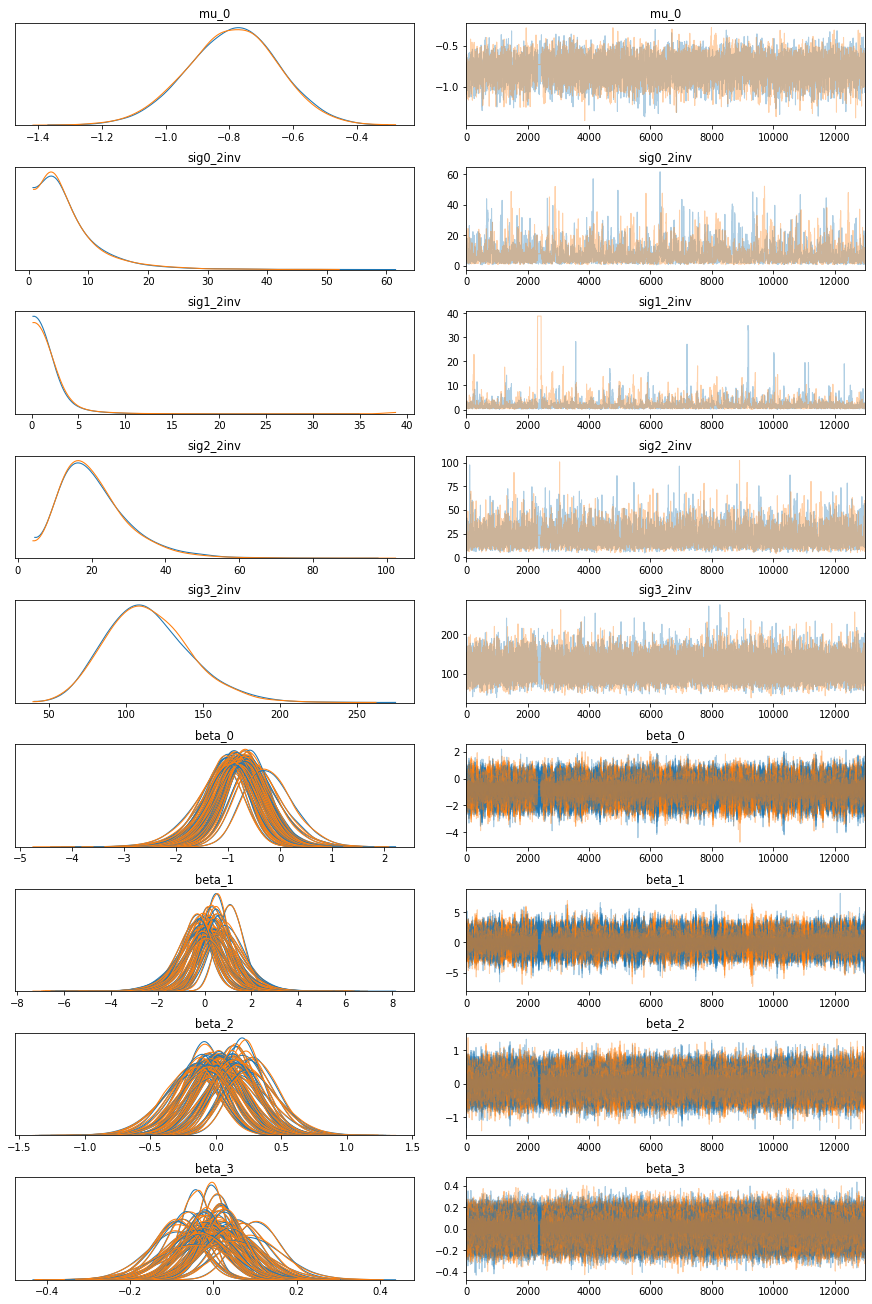

In [19]:
pm.traceplot(big_model_trace, var_names=['mu_0',
                                       'sig0_2inv', 'sig1_2inv', 'sig2_2inv', 'sig3_2inv',
                                       'beta_0', 'beta_1', 'beta_2', 'beta_3'])

sim_results_frame = pm.summary(big_model_trace, var_names=['mu_0',
                                       'sig0_2inv', 'sig1_2inv', 'sig2_2inv', 'sig3_2inv',
                                       'beta_0', 'beta_1', 'beta_2', 'beta_3'])
sim_results_frame

beta_0


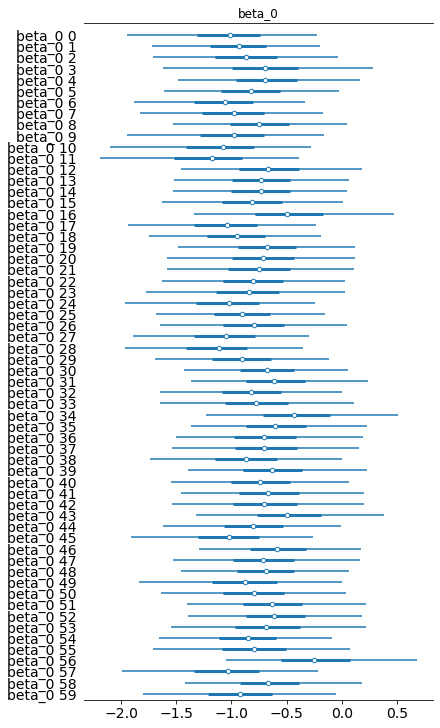

beta_1


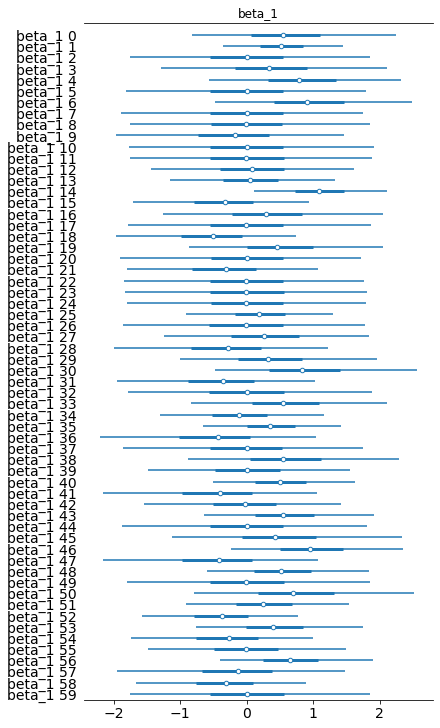

beta_2


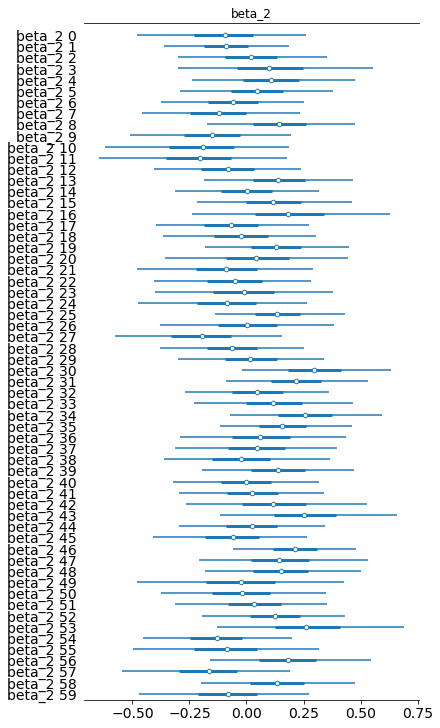

beta_3


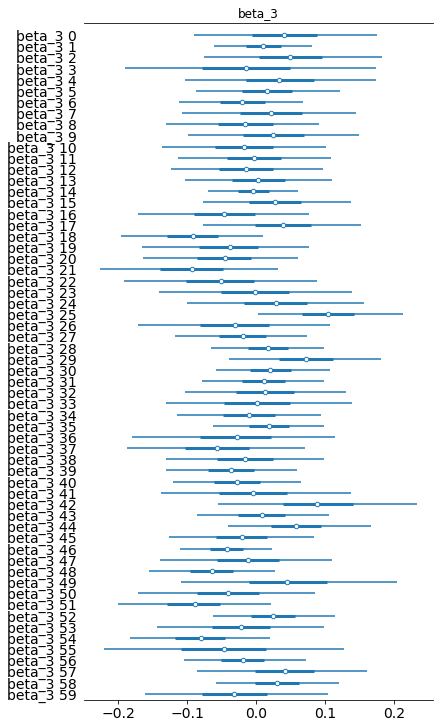

In [20]:
for x in ['beta_0', 'beta_1', 'beta_2', 'beta_3']:
    print(x)
    pm.plot_forest(big_model_trace, var_names=[x], combined=True)
    plt.title(x)
    plt.show()

your response here

**Answer:**

<div style='color:blue'>It looks like there is variation by district for the coefficient on urban, age-mean, as well as living-children.</div>

##### **B2**

Use all of the information you've gleaned thus far to build a final Bayesian logistic regression classifier on the train set. Then, use your model to make predictions on the test set. Report your model's classification percentage.

In [21]:
#your code here

# this is the minimum acceptable procedure- using the posterior means as if they were the true values
# In reality, the posterior may (and probably does) place vanishingly little probability on all parameters
# being near their mean.
#
# We'll use the full model here for the sake of example and to aviod re-fitting.

beta0_means = np.mean(big_model_trace["beta_0"], axis=0)
beta1_means = np.mean(big_model_trace["beta_1"], axis=0)
beta2_means = np.mean(big_model_trace["beta_2"], axis=0)
beta3_means = np.mean(big_model_trace["beta_3"], axis=0)
lin_pred = beta0_means[test_data['district']] \
           + beta1_means[test_data['district']]*test_data['urban'] \
           + beta2_means[test_data['district']]*test_data['living.children'] \
           + beta3_means[test_data['district']]*test_data['age_mean']

# equivalent to predictions = expit(lin_pred) > 0.5
predictions = lin_pred > 0

print("Test Accuracy:    {}".format(np.mean(predictions==test_data['contraceptive_use'])))
print("Trivial Accuracy: {}".format(np.mean(test_data['contraceptive_use']==0)))

Test Accuracy:    0.6194415718717684
Trivial Accuracy: 0.6049638055842813


In [22]:
# A fuller response: uncertainty in the beta values produces uncertainty in the classification rate; 
# there is a distribution over what the classification rate might be. The graph below plots that distribution

# indexing every time in a loop is slow. Just make these variables
district = test_data['district'].values
urban = test_data['urban'].values
living_children = test_data['living.children'].values
age_mean = test_data['age_mean'].values

ground_truth = test_data['contraceptive_use'].values

beta0s = big_model_trace["beta_0"]
beta1s = big_model_trace["beta_1"]
beta2s = big_model_trace["beta_2"]
beta3s = big_model_trace["beta_3"]


classification_rates = []
for i in range(big_model_trace['beta_0'].shape[0]):
    
    lin_pred = beta0s[i, district] \
               + beta1s[i, district]*urban \
               + beta2s[i, district]*living_children \
               + beta3s[i, district]*age_mean

    predictions = lin_pred > 0
    classification_rates.append(np.mean(predictions==ground_truth))


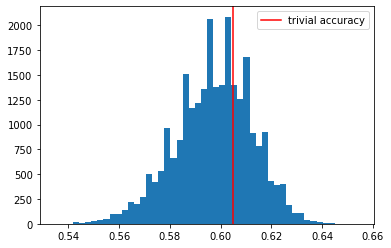

In [23]:
plt.hist(classification_rates, bins=50)
plt.axvline(np.mean(test_data['contraceptive_use']==0), c='r', label="trivial accuracy")
plt.legend()
plt.show()

your response here